In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygame
import seaborn as sns
import random

# our classes
from agentLFA import AgentLFA, QLearningAgentLFA
from environment import Environment
from screen import Screen

# define environment
ACTION_SPACE = np.eye(3)
NUM_ACTIONS = 3
NUM_STATES = 2 ** 11


# Set options to activate or deactivate the game view, and its speed
pygame.font.init()


def plot_metrics(metrics, filepath=None):
    formatted_dict = {'episodes': [],
                      'metrics': [],
                      'results': []}

    n = len(metrics['episodes'])
    for i in range(n):
        episode = metrics['episodes'][i]
        score = metrics['scores'][i]
        reward = metrics['rewards'][i]

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('score')
        formatted_dict['results'].append(score)

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('reward')
        formatted_dict['results'].append(reward)

    df_metrics = pd.DataFrame(formatted_dict)
    sns.lineplot(data=df_metrics, x='episodes', y='results', hue='metrics')
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)

def decode_state(encoded_state):
    """
    Decode a binary representation of a state into its decimal base;

    encoded_state: an array of 0s and 1s representing a binary value

    return: decimal value
    """
    decoded = ''
    for s in encoded_state:
        decoded += str(s)

    return int(decoded, 2)

def decode_action(encoded_action):
    if isinstance(encoded_action, np.ndarray):
        return encoded_action.argmax()
    return encoded_action




pygame 2.0.1 (SDL 2.0.14, Python 3.7.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


Game 1      Score: 0
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 3
Game 6      Score: 0
Game 7      Score: 2
Game 8      Score: 0
Game 9      Score: 0
Game 10      Score: 0
Game 11      Score: 1
Game 12      Score: 0
Game 13      Score: 4
Game 14      Score: 0
Game 15      Score: 0
Game 16      Score: 0
Game 17      Score: 0
Game 18      Score: 1
Game 19      Score: 2
Game 20      Score: 7
Game 21      Score: 4
Game 22      Score: 7
Game 23      Score: 4
Game 24      Score: 4
Game 25      Score: 9
Game 26      Score: 8
Game 27      Score: 6
Game 28      Score: 3
Game 29      Score: 10
Game 30      Score: 9
Game 31      Score: 9
Game 32      Score: 3
Game 33      Score: 3
Game 34      Score: 5
Game 35      Score: 9
Game 36      Score: 11
Game 37      Score: 5
Game 38      Score: 15
Game 39      Score: 12
Game 40      Score: 5
Game 41      Score: 11
Game 42      Score: 5
Game 43      Score: 5
Game 44      Score: 1
Game 45      Score: 3
Game 46      S

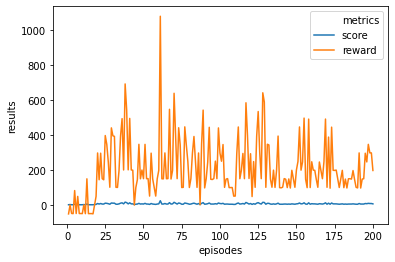

In [2]:
import math
from scipy.spatial import distance

def reward_euclidean(env):
    player_pos = [env.player.x, env.player.y]
    food_pos = [env.food.x_food, env.food.y_food]
    dist = distance.euclidean(player_pos, food_pos)
    reward = 0
    if env.game.crash:
        reward = -10000
    elif env.player.eaten:
        reward = 10000
    else:
        if dist > 100:
            reward = (-1*dist)/10
        if dist <= 100:
            reward = (100-dist)/10

    return reward

def default_reward(env):
    """
    Return the reward.
    The reward is:
        -10 when Snake crashes.
        +10 when Snake eats food
        0 otherwise
    """
    reward = 0
    if env.game.crash:
        reward = -10
    elif env.player.eaten:
        reward = 10

    return reward

def run_q_learning(agent: AgentLFA, reward_function, episodes, display, speed, verbose=True):
    # setting random seed
    random.seed(42)
    np.random.seed(42)

    if display:
        pygame.init()

    env = Environment(440, 440, reward_function)
    screen = Screen(env)

    episode = 0
    metrics = {'episodes': [],
               'scores': [],
               'rewards': []}
    start = time.time()
    while episode < episodes:
        if display:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    quit()

            screen.display()

        state1, done = env.reset()
        #state1 = decode_state(state1)
        action1 = agent.choose_action(state1)
        episode_reward = 0
        while not done:
            # Getting the next state, reward
            state2, reward, done = env.step(action1)
            #state2 = decode_state(state2)
            # Choosing the next action
            action2 = agent.choose_action(state2)

            # Learning the Q-value
            decoded_action1 = decode_action(action1)
            decoded_action2 = decode_action(action2)

            #Calculating Target
            future_actions = []
            for a in range(agent.num_actions):
                future_actions.append(agent.state_value_function(state2,a))

            target = reward + agent.gamma*max(future_actions)

            #agent.update(state1, state2, reward, decoded_action1, decoded_action2)
            agent.update(target, state1, decoded_action1)

            state1 = state2
            action1 = action2
            episode_reward += reward

            if display:
                screen.display()
                pygame.time.wait(speed)

            end = time.time()
            diff = end - start
            if diff > 600: # 10min
                break

        episode += 1
        if verbose:
            print(f'Game {episode}      Score: {env.game.score}')

        mean_reward = episode_reward/episodes
        metrics['episodes'].append(episode)
        metrics['rewards'].append(mean_reward)
        metrics['scores'].append(env.game.score)

        end = time.time()
        diff = end - start
        if diff > 600: # 10min
            break


    return metrics

N0 = 1
gamma = 1

# define agent
qLearningAgent = QLearningAgentLFA(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=reward_euclidean, episodes=200, speed=0, display=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Configurações gerais para a execução dos modelos:

* O espaço de ações é denifido como uma matriz identidade 3x3
* Há três ações possíveis (continuar na mesma direção, virar para a esquerda, virar para a direita)
* Como cada estado é representado por um vetor binário de 11 posições, ao todo há 2^11 estados possíveis

A função de recompensa padrão é definida como:
    
* Ganha 10 pontos por comer a maçã
* Perde 10 pontos por morrer
* Recompensa 0 caso contrário

# Q-Learning

### Experimento 1: Baseline

* N0 = 1
* gamma = 1
* número de episódios = 150